In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from beta_irt.visualization.plots import newline
# from beta_irt.visualization.plots import plot_parameters
# from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import glob
from scipy.stats import spearmanr

In [3]:
name = 'polynomial'

In [4]:
names = []
path = './Results_IRT/'+name+'/'
foldernames = glob.glob(path+'*/')
keys = list(map(lambda x: int(x[:-1].split('_')[-1]), foldernames))
keys = sorted(range(len(keys)), key=lambda k: keys[k])
foldernames = list(map(lambda k: foldernames[k], keys))
names = list(map(lambda x: x.split('/')[-2], foldernames))
max_std = int(names[-1].split('_')[-1])

In [5]:
foldernames

['./Results_IRT/polynomial/noise_0/',
 './Results_IRT/polynomial/noise_1/',
 './Results_IRT/polynomial/noise_2/',
 './Results_IRT/polynomial/noise_3/',
 './Results_IRT/polynomial/noise_4/',
 './Results_IRT/polynomial/noise_5/',
 './Results_IRT/polynomial/noise_6/',
 './Results_IRT/polynomial/noise_7/',
 './Results_IRT/polynomial/noise_8/',
 './Results_IRT/polynomial/noise_9/',
 './Results_IRT/polynomial/noise_10/',
 './Results_IRT/polynomial/noise_11/',
 './Results_IRT/polynomial/noise_12/',
 './Results_IRT/polynomial/noise_13/',
 './Results_IRT/polynomial/noise_14/',
 './Results_IRT/polynomial/noise_15/',
 './Results_IRT/polynomial/noise_16/',
 './Results_IRT/polynomial/noise_17/',
 './Results_IRT/polynomial/noise_18/',
 './Results_IRT/polynomial/noise_19/']

In [6]:
all_files = []
for i, df in enumerate(foldernames):
    path = df
    filenames = glob.glob(path + "/*.csv")
    
    filenames.sort()

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))
        
    all_files.append(dfs)

In [7]:
filenames

['./Results_IRT/polynomial/noise_19/errors_polynomial_s60_f19_sd42.csv',
 './Results_IRT/polynomial/noise_19/irt_ability_vi_polynomial_s60_f19_sd42_am1@0_as1@0.csv',
 './Results_IRT/polynomial/noise_19/irt_data_polynomial_s60_f19_sd42.csv',
 './Results_IRT/polynomial/noise_19/irt_parameters_vi_polynomial_s60_f19_sd42_am1@0_as1@0.csv',
 './Results_IRT/polynomial/noise_19/xtest_polynomial_s60_f19_sd42.csv']

In [8]:
mdls = ['LR', 'Bayes', 'SVR(Linear)', 'SVR(Rbf)', 'KNR', 'DT', 'RF', 'AdaB', 'MLP (100)', 'MLP (50-50)', 'Average', 'Optimal', 'Worst']
abilities = np.zeros((len(mdls), len(foldernames)))
noises = np.zeros((len(all_files[0][-1]), len(foldernames)))
errors = np.zeros((len(foldernames), len(all_files[0][-1]), len(mdls) - 3))
responses = np.zeros((len(foldernames), len(all_files[0][-1]), len(mdls)))
params = np.zeros((len(foldernames), len(all_files[0][-1]), 2))

# Noise x Ability

In [9]:
for i, data in enumerate(all_files):
    abilities[:, i] = data[1].iloc[:-1, -1].values
    errors[i] = data[0].values
    responses[i] = data[2].values
    params[i] = data[3].values

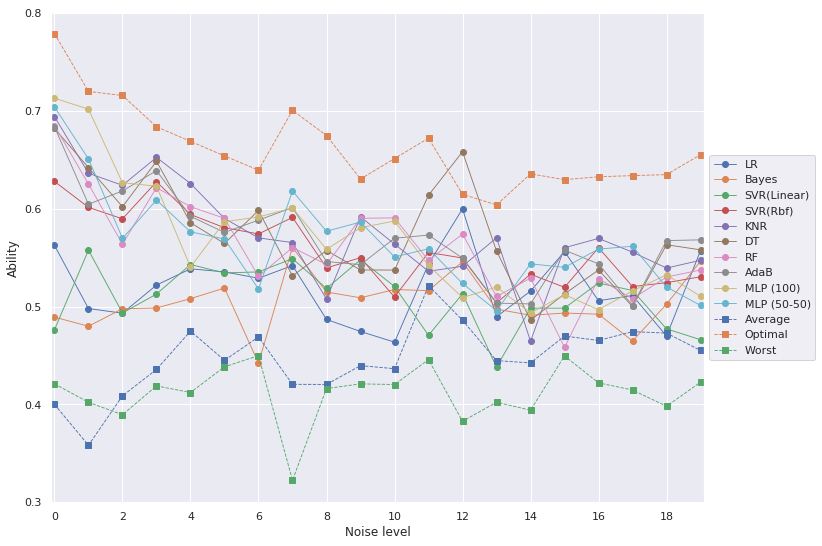

In [34]:
plt.figure(figsize=(18, 9))
for j, model in enumerate(mdls):
    if j>9:
        plt.plot(list(range(20)), abilities[j, :], linewidth=0.9, label=model, marker='s', linestyle = '--')
    else:
        plt.plot(list(range(20)), abilities[j, :], linewidth=0.9, label=model, marker='o')
plt.xticks(range(0, 20, 2))
plt.xlim([-.1,19.1])
plt.ylim([0.3,0.8])

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
legend_x = 1
legend_y = 0.5

plt.ylabel('Ability')
plt.xlabel('Noise level')
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
# plt.savefig('./Results_IRT/' + name + '/ability_noise.png')

# Histograms Responses

In [ ]:
plts = ['Original', 'Noise 1', 'Noise 2']

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))
scale = 0
for i, data in enumerate(all_files[:3]):
    values = data[2].values.reshape(-1,1)
    sns.distplot(values, ax= axes[i])
    current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
    if current_scale > scale:
        scale = current_scale
        y_lim = axes[i].get_ylim()
    axes[i].set_title(plts[i])
    axes[i].set_xlabel('Response value')
    axes[i].set_ylabel('Frequency')
for ax in axes:
    ax.set_ylim(y_lim)
fig.savefig('./Results_IRT/'+name+'/hists.png')

# Difficulty/ Discrimination

In [ ]:
plot = ["Difficulty", "Discrimination"]
#Lower noise
scale = 0
fig, axes = plt.subplots(2, 2, figsize=(12,12))

for i, title in enumerate(plot):
    for j in range(1,3):
        if i == 0:
            lim = np.array([0,1])
        else:
            lim = np.array([-0.2, 1.2])
        
        axes[i,j-1].set_xlim(lim)
        axes[i,j-1].set_ylim(lim)
        axes[i,j-1].plot([lim[0],lim[1]], [lim[0], lim[1]], linewidth=0.2, c='black')        
        
        sns.set_context('paper')
        cmap1 = sns.cubehelix_palette(rot=-.5,light=1.5,dark=-.5,as_cmap=True)

        axes[i,j-1].text(x = lim[0], y = lim[0], s='Corr = %.2f' %(spearmanr(a = all_files[0][2].iloc[:,i], b = all_files[j][2].iloc[:,i])[0]))
        axes[i, j-1].scatter(all_files[0][2].iloc[:,i], all_files[j][2].iloc[:,i], c = np.absolute(all_files[j][3].iloc[:,-1]), cmap = cmap1, edgecolor='k',s=30)

        axes[i,j-1].set_xlabel("Original data")
        axes[i,j-1].set_ylabel(plts[j])
        axes[i,j-1].set_title(title)
fig.savefig('./Results_IRT/'+name+'/parameters.png')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, noisy in enumerate(names):
    if i>0:
        c = np.absolute(all_files[i][3].iloc[:,-1])
    else:
        c = np.zeros(len(all_files[i][2]))
    axes[i].scatter(all_files[i][2].iloc[:,0], all_files[i][2].iloc[:,1], c = c, cmap = cmap1, edgecolor='k',s=30)
    axes[i].set_title(plts[i])
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([-0.2, 1.2])
    axes[i].set_xlabel('Difficulty')
    axes[i].set_ylabel('Discrimination')
fig.savefig('./Results_IRT/'+name+'/dif_disc')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for h, param in enumerate(['Diff', 'Discrim']):
    for i in range(2):
        axes[h, i].scatter(np.absolute(all_files[i+1][3].iloc[:, -1]), (all_files[i+1][2].iloc[:,h] - all_files[0][2].iloc[:,h]), edgecolor='k',s=30)
        axes[h, i].set_ylim([-1., 1.])
        axes[h, i].set_xlim([-.2, 3*max_std])
        axes[h, i].text(x = -.2, y = -1, s='Corr = %.2f' %(spearmanr(a = np.absolute(all_files[i+1][3].iloc[:, -1]), b = (all_files[i+1][2].iloc[:,h] - all_files[0][2].iloc[:,h]))[0]))

        axes[h, i].set_xlabel('|Noise|')
        axes[h, i].set_ylabel('Δ '+param+' ('+plts[i+1]+' - Original)')
fig.savefig('./Results_IRT/'+name+'/param_noise')

# Ability

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
mdls = mdls = ['LR', '  Bayes', ' SVR(L)', ' SVR(R)', 'KNR', 'DT', 'RF', 'AdaB', 'MLP100', 'MLP50-50', 'Opt', 'Avg', 'Wrs']
lim = [0.4, 0.7]

for i, noisy in enumerate(plts[1:]):
    axes[i].scatter(all_files[0][0].iloc[:-1, -1], all_files[i+1][0].iloc[:-1, -1], edgecolor='k')
    for j, txt in enumerate(mdls):
        axes[i].text(all_files[0][0].iloc[j, -1], all_files[i+1][0].iloc[j, -1], ' '+txt, fontsize=7)
    axes[i].set_xlim(lim)
    axes[i].set_ylim(lim)
    axes[i].set_xlabel('Original')
    axes[i].set_ylabel(noisy)
    axes[i].set_title('Ability')
    axes[i].plot(lim, lim, linewidth=0.2, c='black')
fig.savefig('./Results_IRT/'+name+'/ability')

# Error

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, error in enumerate(all_errors):
    if i>0:
        c = np.absolute(all_files[i][3].iloc[:,-1])
    else:
        c = np.zeros(len(all_files[i][2]))
    mean_error = np.absolute(error).mean(axis = 1)
    diff = all_files[i][2].iloc[:,0]
    axes[i].scatter(diff,mean_error, c= c, cmap = cmap1, edgecolor='k',s=30)
    axes[i].text(x = 0, y = 0, s='Mean = %.2f Std = %.2f Corr = %.2f' %(mean_error.mean(), mean_error.std(), spearmanr(a = diff, b = mean_error)[0]), fontsize=10)
    axes[i].set_xlabel('Difficulty')
    axes[i].set_ylabel('Mean Error (Instance)')
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([0, 20])
    axes[i].set_title(plts[i])
fig.savefig('./Results_IRT/'+name+'/diff_error')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
for i, error in enumerate(all_errors[1:]):
    mean_error = np.absolute(error).mean(axis = 1)
    noise = all_files[i+1][3].iloc[:, -1]
    axes[i].scatter(np.absolute(noise), mean_error, edgecolor='k',s=30)
    axes[i].text(x = 0, y = 0, s='Corr = %.2f' %(spearmanr(a = diff, b = mean_error)[0]), fontsize=10)
    axes[i].set_xlabel('|Noise|')
    axes[i].set_ylabel('Mean Error (Instance)')
    axes[i].set_xlim([-0.2,20])
    axes[i].set_ylim([0, 20])
    axes[i].set_title(plts[i+1])
fig.savefig('./Results_IRT/'+name+'/noise_error')

In [ ]:
for h, param in enumerate(plot):
    sns.set_context('paper')
    scale = 0
    fig, axes = plt.subplots(1, 3, figsize=(18,2))
    for i, data in enumerate(all_files):
        values = data[2].iloc[:, h].values.reshape(-1,1)
        sns.distplot(values,bins=100,ax=axes[i])
        sns.distplot(values, ax= axes[i])
        current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
        if current_scale > scale:
            scale = current_scale
            y_lim = axes[i].get_ylim()
        axes[i].set_title(param + ' (' + plts[i] + ')')
        axes[i].set_ylabel('Frequency')
    for ax in axes:
        ax.set_ylim(y_lim)
    fig.subplots_adjust(hspace=0.3)
    fig.savefig('./Results_IRT/'+name+'/hists_' + param + '.png')

In [ ]:
for i, noise in enumerate(plts):
    metrics = pd.DataFrame()
    metrics['Avg. Response'] = all_files[i][1].iloc[:, :-3].mean(axis = 0)
    metrics['Ability'] = all_files[i][0].iloc[:-4, 1].values
    metrics['MAE'] = np.absolute(all_errors[i]).mean(axis = 0)
    metrics['MSE'] = (all_errors[i]**2).mean(axis = 0)
    print(noise,'\n',metrics.corr(method = 'spearman'),'\n\n')